In [8]:
# BLOQUE 1: Limpieza y Construcción del Año Típico (TMY) + Suavizado

import pandas as pd
import os

# Cargar el archivo
ruta_archivo = '/home/miguelo/datasciencesolar/MiguelOlivares/antofagasta_dirty.csv'
df_dirty = pd.read_csv(ruta_archivo)

# Crear columna Timestamp
df_dirty['Timestamp'] = pd.to_datetime(df_dirty[['Year', 'Month', 'Day', 'Hour', 'Minute']])

# Definir columnas a trabajar
columnas = ['GHI', 'DNI', 'DHI', 'Tdry', 'Tdew', 'RH', 'Pres', 'Wspd', 'Wdir', 'Snow Depth']

# Asegurar que las columnas son numéricas
df_dirty[columnas] = df_dirty[columnas].apply(pd.to_numeric, errors='coerce')

# --- Corrección de valores físicos ---
df_dirty['GHI'] = df_dirty['GHI'].clip(lower=0, upper=1500)
df_dirty['DNI'] = df_dirty['DNI'].clip(lower=0, upper=1500)
df_dirty['DHI'] = df_dirty['DHI'].clip(lower=0, upper=1500)

# --- Interpolación lineal ---
df_dirty[columnas] = df_dirty[columnas].interpolate(method='linear')
df_dirty[columnas] = df_dirty[columnas].fillna(method='bfill').fillna(method='ffill')

# --- CREAR EL AÑO TÍPICO COMPLETO ---
# Crear un rango de tiempo 8760 horas (año 2000)
tmy_tiempo = pd.date_range(start='2000-01-01 00:00', end='2000-12-31 23:00', freq='H')

# Crear DataFrame vacío
df_tmy = pd.DataFrame({'Timestamp': tmy_tiempo})

# Asignar datos existentes (ajustar tamaño)
for col in columnas:
    if len(df_dirty) >= len(df_tmy):
        df_tmy[col] = df_dirty[col].iloc[:len(df_tmy)].values
    else:
        df_tmy[col] = df_dirty[col].values.tolist() + [0]*(len(df_tmy)-len(df_dirty))

# --- SUAVIZADO del GHI, DNI y DHI ---
df_tmy['GHI'] = df_tmy['GHI'].rolling(window=12, center=True, min_periods=1).mean()
df_tmy['DNI'] = df_tmy['DNI'].rolling(window=12, center=True, min_periods=1).mean()
df_tmy['DHI'] = df_tmy['DHI'].rolling(window=12, center=True, min_periods=1).mean()

# Rellenar posibles NaNs
df_tmy.fillna(0, inplace=True)

# Guardar el archivo limpio y estructurado como TMY
ruta_guardado = '/home/miguelo/datasciencesolar/MiguelOlivares/antofagasta_tmy.csv'
df_tmy.to_csv(ruta_guardado, index=False)

print("✅ Archivo limpio, suavizado y estructurado como TMY guardado en:", ruta_guardado)



✅ Archivo limpio, suavizado y estructurado como TMY guardado en: /home/miguelo/datasciencesolar/MiguelOlivares/antofagasta_tmy.csv


/tmp/ipykernel_22350/1453167001.py:26: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_dirty[columnas] = df_dirty[columnas].fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_22350/1453167001.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tmy_tiempo = pd.date_range(start='2000-01-01 00:00', end='2000-12-31 23:00', freq='H')


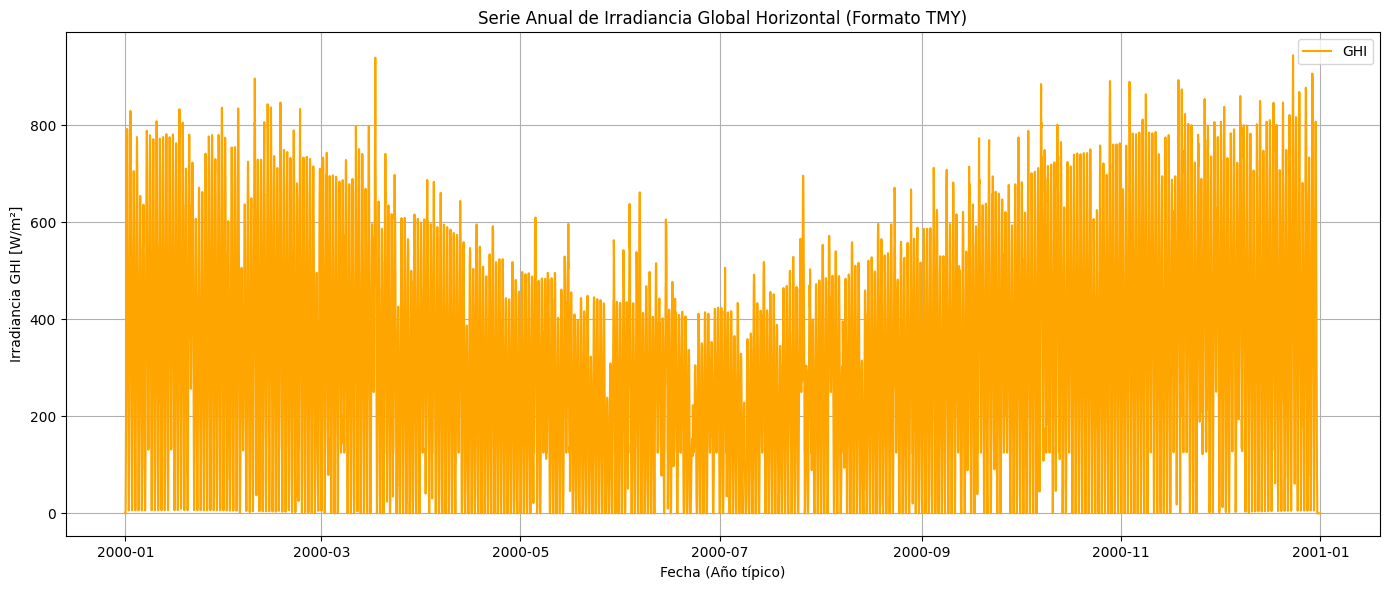

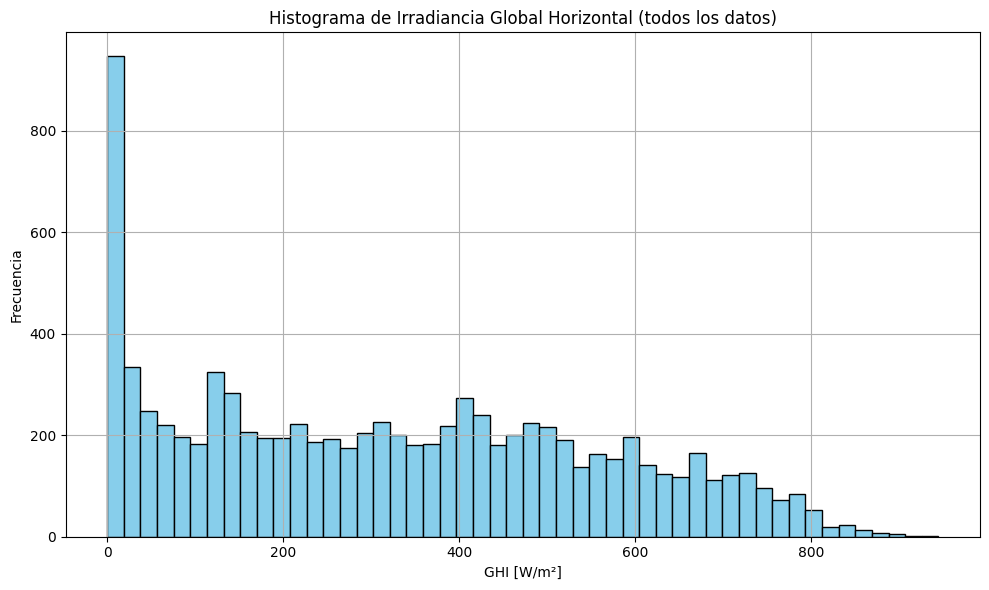

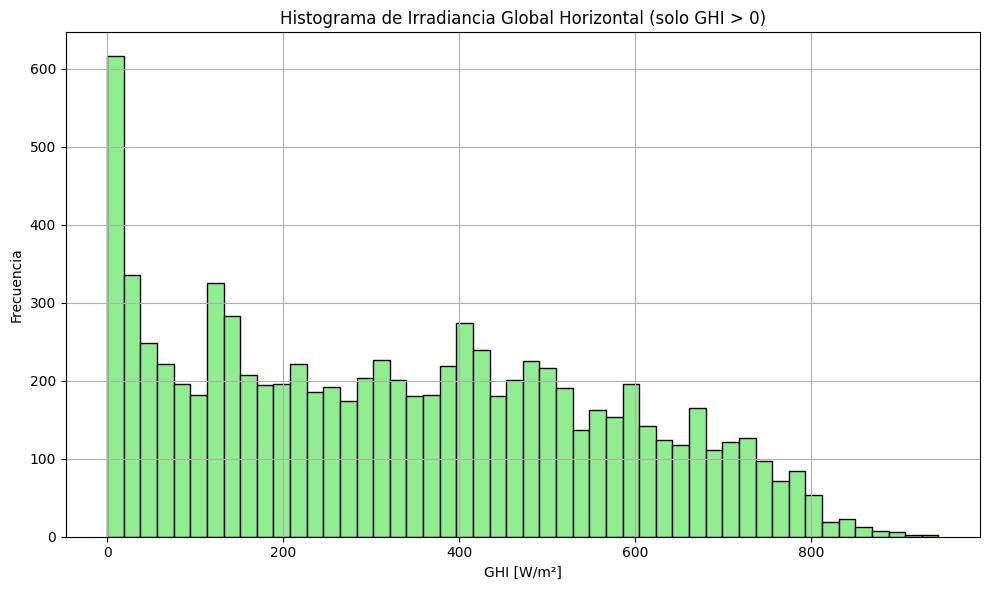

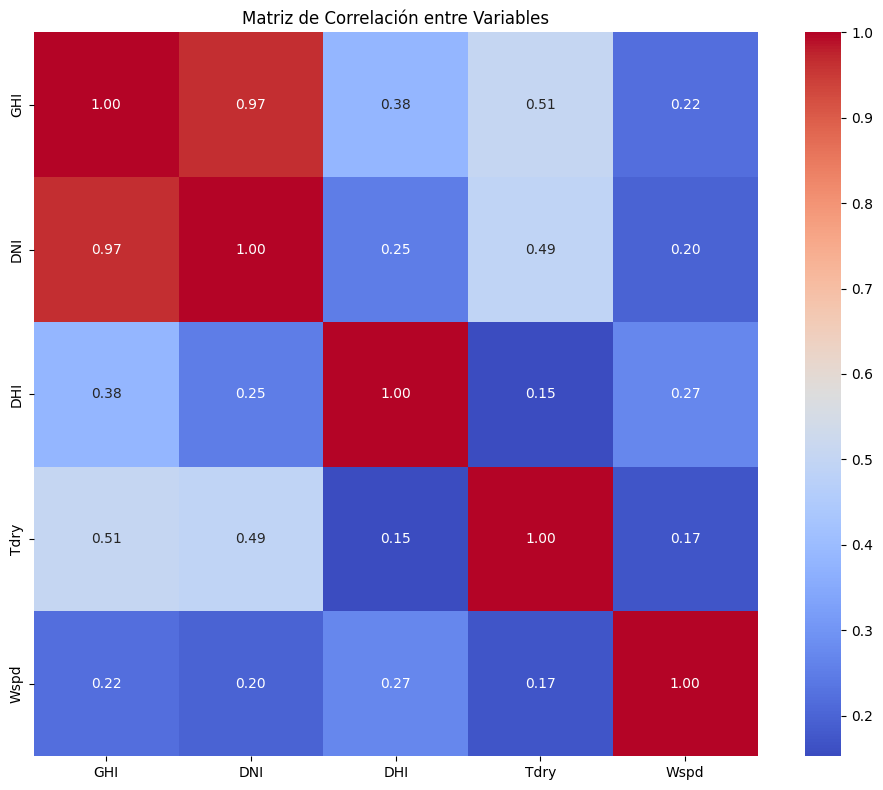

✅ Gráficos guardados en la carpeta: /home/miguelo/datasciencesolar/MiguelOlivares/graficos


In [9]:
# BLOQUE 2: Gráficos de Exploración sobre archivo TMY limpio

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ruta del archivo limpio TMY
ruta_tmy = '/home/miguelo/datasciencesolar/MiguelOlivares/antofagasta_tmy.csv'

# Cargar datos
df_tmy = pd.read_csv(ruta_tmy)

# Convertir Timestamp
df_tmy['Timestamp'] = pd.to_datetime(df_tmy['Timestamp'])

# Crear carpeta para guardar gráficos
carpeta_guardado = '/home/miguelo/datasciencesolar/MiguelOlivares/graficos'
os.makedirs(carpeta_guardado, exist_ok=True)

# --- Gráfico 1: Serie anual de GHI (Formato TMY)
plt.figure(figsize=(14, 6))
plt.plot(df_tmy['Timestamp'], df_tmy['GHI'], label='GHI', color='orange')
plt.xlabel('Fecha (Año típico)')
plt.ylabel('Irradiancia GHI [W/m²]')
plt.title('Serie Anual de Irradiancia Global Horizontal (Formato TMY)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(f'{carpeta_guardado}/serie_anual_GHI_TMY.png')
plt.show()

# --- Gráfico 2A: Histograma de GHI (todos los datos)
plt.figure(figsize=(10, 6))
plt.hist(df_tmy['GHI'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('GHI [W/m²]')
plt.ylabel('Frecuencia')
plt.title('Histograma de Irradiancia Global Horizontal (todos los datos)')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{carpeta_guardado}/histograma_GHI_completo_TMY.png')
plt.show()

# --- Gráfico 2B: Histograma solo GHI > 0
df_ghi_solar = df_tmy[df_tmy['GHI'] > 0]

plt.figure(figsize=(10, 6))
plt.hist(df_ghi_solar['GHI'], bins=50, color='lightgreen', edgecolor='black')
plt.xlabel('GHI [W/m²]')
plt.ylabel('Frecuencia')
plt.title('Histograma de Irradiancia Global Horizontal (solo GHI > 0)')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{carpeta_guardado}/histograma_GHI_sol_TMY.png')
plt.show()

# --- Gráfico 3: Matriz de Correlación entre Variables
columnas_corr = ['GHI', 'DNI', 'DHI', 'Tdry', 'Wspd']
matriz_corr = df_tmy[columnas_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Matriz de Correlación entre Variables')
plt.tight_layout()
plt.savefig(f'{carpeta_guardado}/matriz_correlacion_TMY.png')
plt.show()

print(f"✅ Gráficos guardados en la carpeta: {carpeta_guardado}")



In [10]:
# --- BLOQUE: Simulación con PySAM usando TMY corregido ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PySAM.Pvwattsv8 as pv
from datetime import datetime

# 1. Cargar el TMY corregido
ruta_tmy = '/home/miguelo/datasciencesolar/MiguelOlivares/antofagasta_tmy.csv'
df_tmy = pd.read_csv(ruta_tmy)

# Crear columna Timestamp
df_tmy['Timestamp'] = pd.date_range(start='2000-01-01 00:00', end='2000-12-31 23:00', freq='H')

# 2. Crear columnas para archivo SAM
df_tmy['Year'] = df_tmy['Timestamp'].dt.year
df_tmy['Month'] = df_tmy['Timestamp'].dt.month
df_tmy['Day'] = df_tmy['Timestamp'].dt.day
df_tmy['Hour'] = df_tmy['Timestamp'].dt.hour
df_tmy['Minute'] = 0  # Minuto fijo para PVWatts

# 3. Armar DataFrame para PySAM
df_sam = df_tmy[['Year', 'Month', 'Day', 'Hour', 'Minute', 'GHI', 'DNI', 'DHI', 'Tdry', 'Wspd']].copy()
df_sam.columns = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'GHI', 'DNI', 'DHI', 'Temperature', 'Wind Speed']

# 4. Guardar CSV estilo SAM en la carpeta correcta
ruta_sam = '/home/miguelo/datasciencesolar/MiguelOlivares/antofagasta_tmy_sam.csv'
with open(ruta_sam, 'w') as f:
    f.write('latitude,longitude,timezone,elevation\n')
    f.write('-23.6,-70.4,-4,1000\n')
    f.write('Year,Month,Day,Hour,Minute,GHI,DNI,DHI,Temperature,Wind Speed\n')
    df_sam.to_csv(f, index=False, header=False)

print(f"✅ Archivo SAM creado y guardado en: {ruta_sam}")

# 5. Simulación PySAM
modelo = pv.new()
modelo.SolarResource.solar_resource_file = ruta_sam

# Parámetros de la planta
modelo.SystemDesign.system_capacity = 100000  # 100 MW
modelo.SystemDesign.dc_ac_ratio = 1.1
modelo.SystemDesign.module_type = 0  # Standard
modelo.SystemDesign.array_type = 1   # Fixed Open Rack
modelo.SystemDesign.tilt = 23
modelo.SystemDesign.azimuth = 0
modelo.SystemDesign.gcr = 0.4
modelo.SystemDesign.inv_eff = 96
modelo.SystemDesign.losses = 14.0

modelo.execute()

# 6. Resultados
energia_kwh = modelo.Outputs.annual_energy
energia_mwh = round(energia_kwh / 1000, 2)

# 7. Guardar resumen
fecha_simulacion = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
df_resumen = pd.DataFrame({
    "Fecha de Simulación": [fecha_simulacion],
    "Capacidad (MW)": [100],
    "DC/AC Ratio": [1.1],
    "Tilt (°)": [23],
    "Azimuth (°)": [0],
    "GCR": [0.4],
    "Eficiencia Inversor (%)": [96],
    "Pérdidas (%)": [14.0],
    "Energía Anual (MWh)": [energia_mwh]
})

ruta_resumen = '/home/miguelo/datasciencesolar/MiguelOlivares/resumen_simulacion_100MW_tmy.csv'
df_resumen.to_csv(ruta_resumen, index=False)

print(f"\n✅ Resumen de simulación guardado en: {ruta_resumen}")

# 8. Mostrar resumen
print("\n📋 --- RESUMEN DE LA SIMULACIÓN --- 📋\n")
print(df_resumen.to_string(index=False))


✅ Archivo SAM creado y guardado en: /home/miguelo/datasciencesolar/MiguelOlivares/antofagasta_tmy_sam.csv

✅ Resumen de simulación guardado en: /home/miguelo/datasciencesolar/MiguelOlivares/resumen_simulacion_100MW_tmy.csv

📋 --- RESUMEN DE LA SIMULACIÓN --- 📋

Fecha de Simulación  Capacidad (MW)  DC/AC Ratio  Tilt (°)  Azimuth (°)  GCR  Eficiencia Inversor (%)  Pérdidas (%)  Energía Anual (MWh)
2025-04-26 11:24:16             100          1.1        23            0  0.4                       96          14.0            184904.63


/tmp/ipykernel_22350/1514412128.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_tmy['Timestamp'] = pd.date_range(start='2000-01-01 00:00', end='2000-12-31 23:00', freq='H')
